In [67]:
%reset -f

In [68]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import cv2

我设计的二维多尺度插值小波欲逼近的原函数的定义域是[-1,1]×[-1,1]，在这个区域上定义了一个二维函数

定义以下变量：xc是x轴的坐标，xr是y轴的坐标，imgl是函数值

In [69]:
xc = torch.arange(-1,1,1/256).reshape((-1,1))  # 二维函数的列坐标, N个(这里取512), 范围是[-1,1]
xr = xc.clone()  # 二维函数的行坐标, M个(这里是图省事，可以定义任意数量), 范围是[-1,1]
imgl = torch.sin(2*xc).reshape((-1,1)) @ torch.cos(5*xr).reshape((1,-1))  # 一个M*N的函数图像(这里是512x512的矩阵)

print("xc shape: {}".format(xc.shape))
print("xr shape: {}".format(xr.shape))
print("imgl shape: {}".format(imgl.shape))

xc shape: torch.Size([512, 1])
xr shape: torch.Size([512, 1])
imgl shape: torch.Size([512, 512])


多尺度插值小波的逼近，至少需要以下超参数：

- $j0$: 多尺度插值小波的最初分解尺度

- $J$: 多尺度插值小波的最终分解尺度

- $e$: 逼近误差, 即实现**自适应**多尺度插值小波的阈值


In [70]:
j0 = 0  # 多尺度插值小波的最初分解尺度, 这里取0, 可以是任意正整数值
J = 5  # 多尺度插值小波的最终分解尺度, 这里取5, 也可以是任意正整数值, J >= j0
e = 0.02  # 逼近误差, 即实现自适应多尺度插值小波的阈值, 这里取0.02

此外最核心的是，需要 **“插值尺度函数$\phi$”** 和 **“插值小波函数$\psi$”**

由于插值小波中，插值小波函数$\psi_{j,k}=\phi_{j+1, 2k+1}$，因此只定义插值尺度函数。插值小波函数由该关系直接求得


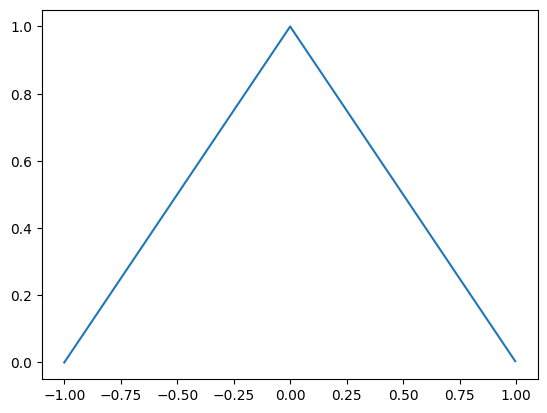

In [71]:
def get_phi(x):  # 插值尺度函数 phi, 这里使用FS小波
    out = torch.zeros_like(x)
    out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
    out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
    return out

    # 下面这个是拟香农小波
    # mm = (3.2**2) * (1**2)
    # t = torch.pi * x / 1
    # ss = torch.sin(t)
    # ee = torch.exp(-torch.square(x) / (2 * mm))
    # out = torch.divide((ss * ee), t)
    # out[torch.where(t==0.)] = 1.
    # return out

# 可视化插值尺度函数 phi
phi_c = get_phi(xc)  # xc 是[512, 1]的张量，得到的phi_c也是[512, 1]的张量
plt.plot(xc, phi_c)

函数可以处理[512, N]的输入张量，也就是可以同时处理N个输入。

比如，设置一个[512, 3]的tensor作为输入，则能够得到[512, 3]的输出

现在求取j=0时所有的插值尺度函数, $j$尺度下的尺度函数索引$k$与$j$的关系是：$k \in [-2^j, 2^j]$, 那么j=0时这里有$k=-1, 0, 1$

这里利用tensor的广播机制，就可快速得到一个[512, 3]的张量，也即$\phi_{0,-1}, \phi_{0, 0}和\phi_{0, 1}$对应的输入自变量

In [72]:
kc = torch.arange(-1, 2, 1)
print("kc: {}".format(kc))
xc_N = (2**0)*xc - kc
print("xc_N shape: {}".format(xc_N.shape))

kc: tensor([-1,  0,  1])
xc_N shape: torch.Size([512, 3])


进而得到插值尺度函数：$\phi_{j,k}=\phi(2^jx-k)$

可以看到，这样能够预先一次性求出一个尺度下所有的插值尺度函数

phi_cN shape: torch.Size([512, 3])


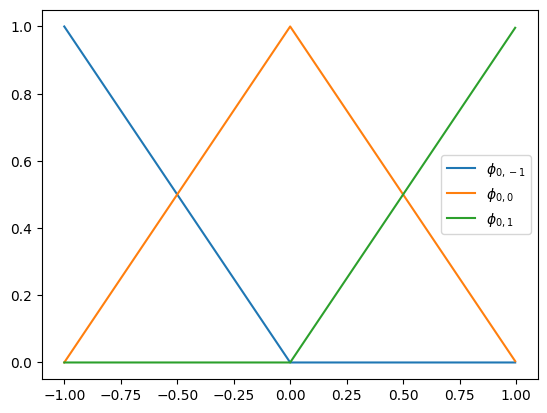

In [73]:
phi_cN = get_phi(xc_N)
print("phi_cN shape: {}".format(phi_cN.shape))
# 画图
for i in range(3):
    plt.plot(xc, phi_cN[:,i])
plt.legend(["$\phi_{0, -1}$", "$\phi_{0,0}$", "$\phi_{0,1}$"])

同理, j=1时有$k=-2, -1, 0, 1, 2$

一系列计算后可得到j=1尺度下所有的插值尺度函数

phi_cN shape: torch.Size([512, 5])


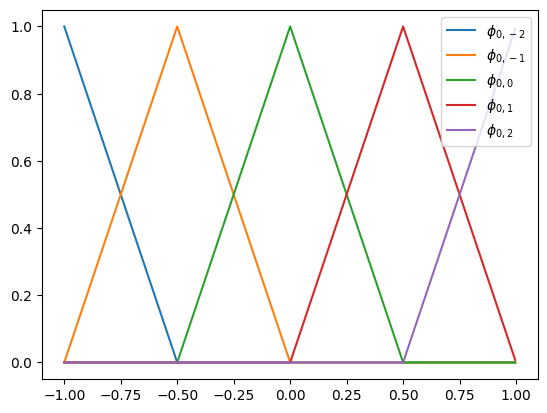

In [74]:
kc = torch.arange(-2, 3, 1)
xc_N = (2**1)*xc - kc
phi_cN = get_phi(xc_N)
print("phi_cN shape: {}".format(phi_cN.shape))
# 画图
for i in range(5):
    plt.plot(xc, phi_cN[:,i])
plt.legend(["$\phi_{0, -2}$", "$\phi_{0, -1}$", "$\phi_{0,0}$", "$\phi_{0,1}$", "$\phi_{0,2}$"])

以上是一维的部分，推广到二维，需要对一维尺度函数作张量积。先看单个二维插值小波是如何得到的

以列坐标xc对应的，中心点在x=0处的插值尺度函数值，也就是 $\phi^c_{0,0}$ 和行坐标xr对应的 $\phi^r_{0,0}$

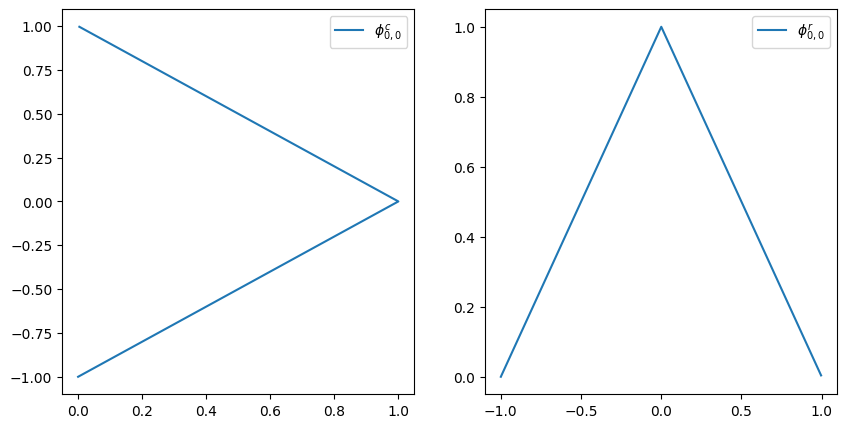

In [75]:
xc_w_phi = get_phi(xc)
fig, axs= plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(xc_w_phi, xc)
axs[0].legend(["$\phi^c_{0,0}$"])
xr_w_phi = get_phi(xr)
axs[1].plot(xr, xr_w_phi)
axs[1].legend(["$\phi^r_{0,0}$"])

张量积就是  $\phi^c_{0,0} \times \phi^r_{0,0}$  如下：

phi2d shape: torch.Size([512, 512])


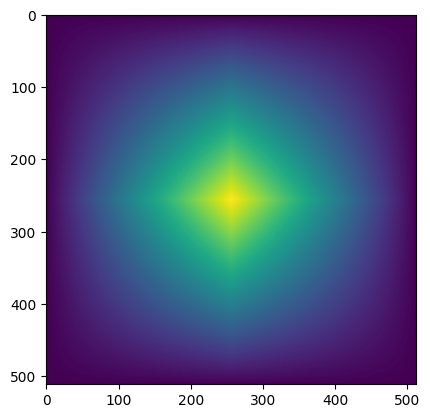

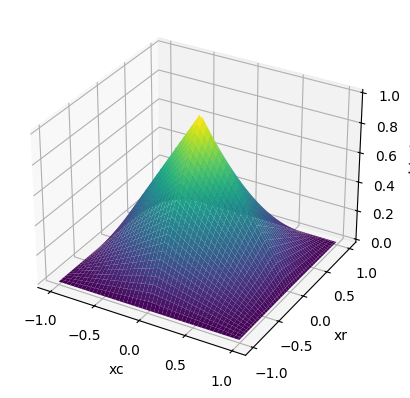

In [76]:
phi2d = torch.einsum('ij,jk->ik', [xc_w_phi, xr_w_phi.transpose(0, 1)])
print("phi2d shape: {}".format(phi2d.shape))
# 二维图像
plt.imshow(phi2d.numpy(), cmap='viridis')
# 三维图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
XR, XC = torch.meshgrid(xr[:,0], xc[:,0])
ax.plot_surface(XC.numpy(), XR.numpy(), phi2d.numpy(), cmap='viridis')
ax.set_xlabel('xc')
ax.set_ylabel('xr')
ax.set_zlabel('phi2d')
plt.show()

显然，二维插值尺度函数，j=0时，有3×3=9个； j=1时，有5×5=25个。j尺度下共 $(2^{(j+1)}+1) \times (2^{(j+1)}+1)$ 个。

以求取j=0下的二维插值尺度函数为例：我们要求出 $\phi^{j=0}_{-1,-1}(x)$ 到 $\phi^{j=0}_{1,1}(x)$ 共9个插值尺度函数

最简单的方式是逐个求出，即以下代码：

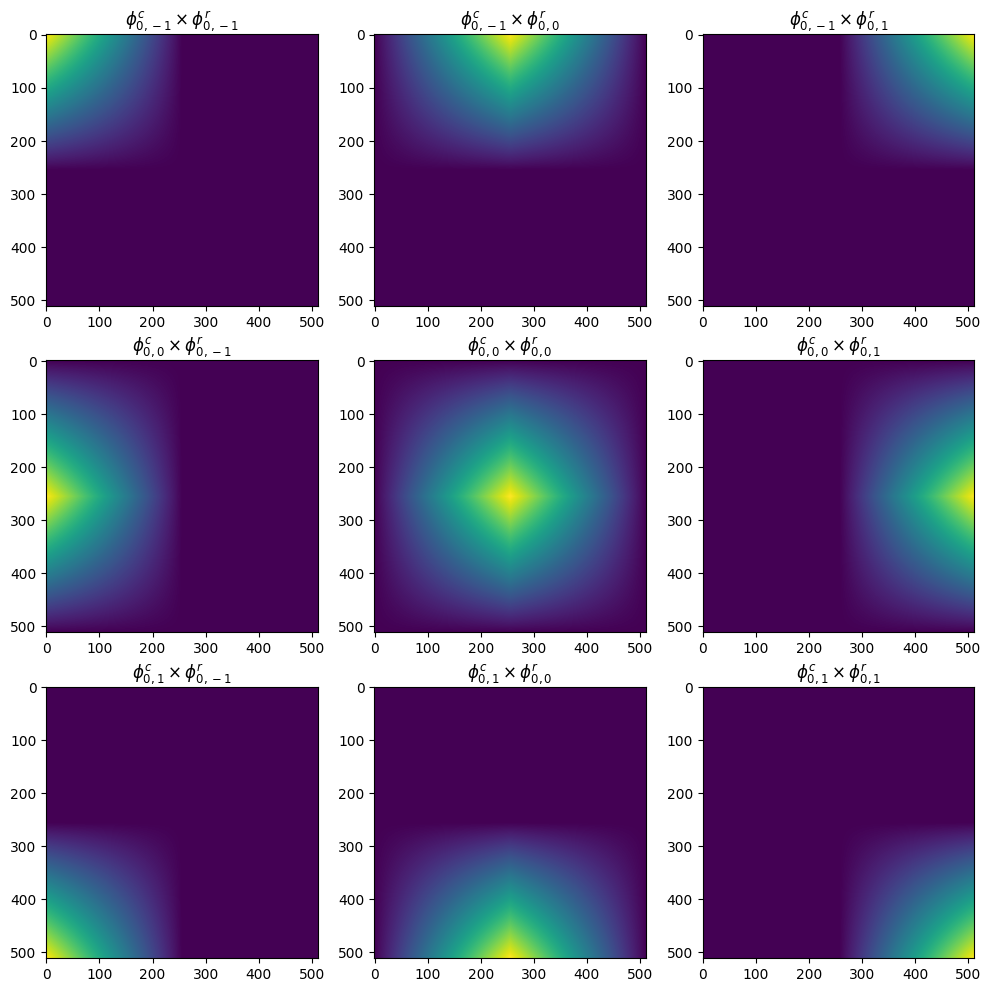

In [77]:
kc = torch.arange(-1, 2, 1)
kr = torch.arange(-1, 2, 1)

figs, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    xc_N = (2**0)*xc - kc[i]

    for j in range(3):
        xr_N = (2**0)*xr - kr[j]   

        phi2d = torch.einsum('ij,jk->ik', [get_phi(xc_N), get_phi(xr_N).transpose(0, 1)])
        axs[i, j].imshow(phi2d.numpy(), cmap='viridis')
        axs[i, j].set_title("$\phi^c_{0, %d} \\times \phi^r_{0, %d}$" % (kc[i], kr[j]))

在此前利用广播机制一次性求出j尺度下的输入自变量，也就是上部分代码中的xc_N和xr_N

In [78]:
kc = torch.arange(-1, 2, 1)
kr = torch.arange(-1, 2, 1)

xc_N = (2**0)*xc - kc
xr_N = (2**0)*xr - kr

那么求取二维插值尺度函数的代码可改为

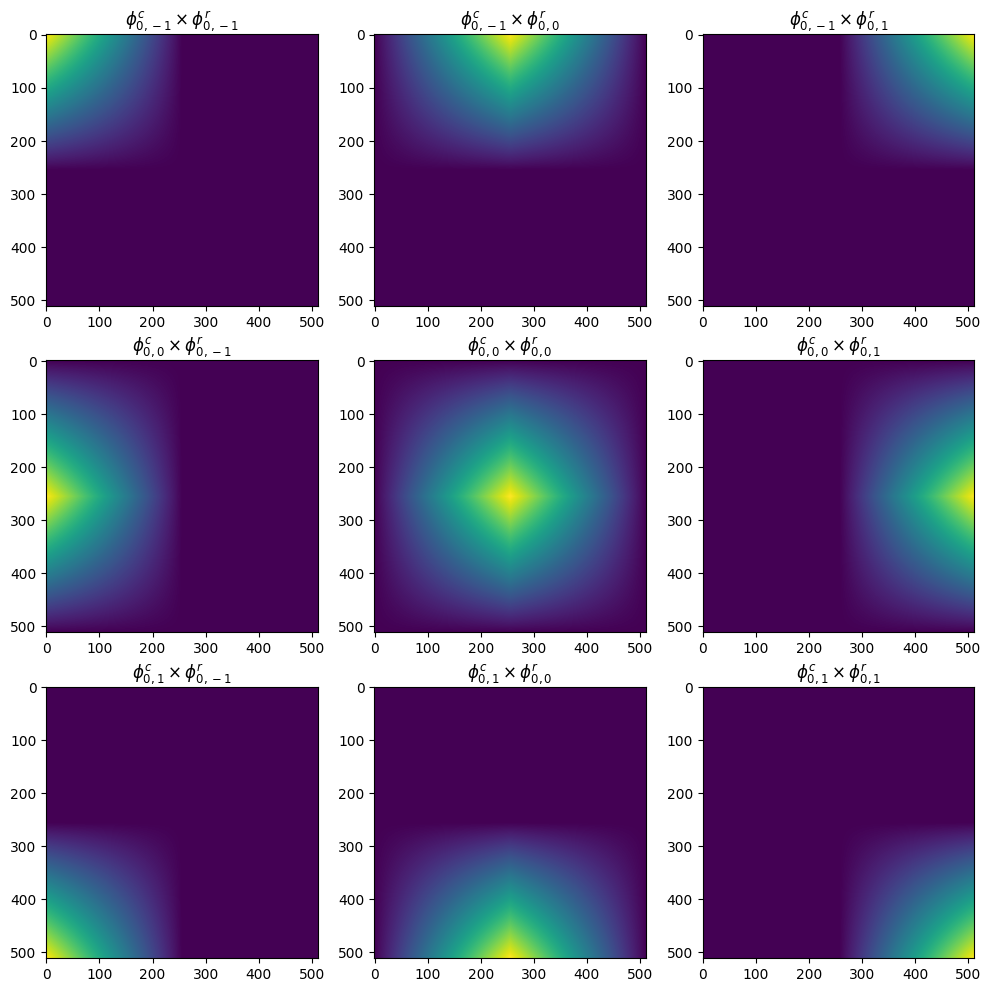

In [79]:
figs, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        phi2d = torch.einsum('ij,jk->ik', [get_phi(xc_N[:,i].reshape(-1,1)), get_phi(xr_N[:,j].reshape(-1,1)).transpose(0, 1)])
        axs[i, j].imshow(phi2d.numpy(), cmap='viridis')
        axs[i, j].set_title("$\phi^c_{0, %d} \\times \phi^r_{0, %d}$" % (kc[i], kr[j]))

显然，这样求取本质上还是一个个求。但是可看到，这九个张量积的过程，第一行的三个函数，是 $\phi^c_{0, -1}$ 和 所有的 $\phi^r$ 分别张量积得到的。

在这里 $\phi^c_{0, -1}$ 和所有的 $\phi^r$ 均是一个(512,1)的tensor, 张量积不过是(512, 1)和(1, 512)的矩阵相乘

若同时求得一行的二维插值尺度函数，可以将其实现为**同一个(512, 1)的向量** 和 (3, 512)的 矩阵的每一行相乘，会得到3个(512, 512)的矩阵。

**同一个(512, 1)的向量**使用3次，也即使用**每一列完全相同的(512, 3)的矩阵**的每个列向量1次。


那我们首先实现这样一个**每一列完全相同的(512, 3)的矩阵**, 使用repeat_interleave函数

xc_w_phi1_tmp shape: torch.Size([512, 3])


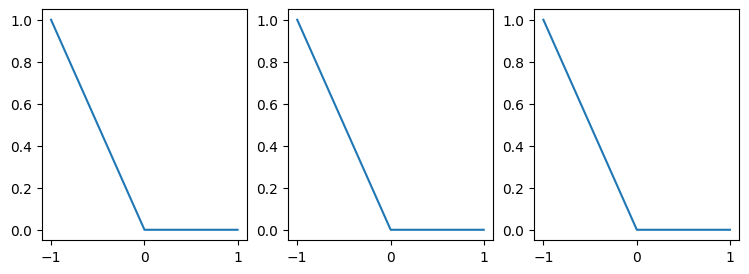

In [80]:
xc_w_phi = get_phi(xc_N[:,0].reshape(-1,1))  # 一维插值尺度函数 phi
xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr_N.shape[1], 1)
print("xc_w_phi1_tmp shape: {}".format(xc_w_phi1_tmp.shape))
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    axs[i].plot(xc, xc_w_phi1_tmp[:,i])

(512, 3) 和 (3, 512) 的矩阵相乘，得到的是(512, 512)的矩阵。
我们将矩阵的乘法过程拆分，只用前面的一半步骤，也就是得到3个(512, 512)的未加和子矩阵。使用einsum函数实现（爱因斯坦求和）

phi2d shape: torch.Size([512, 512, 3])


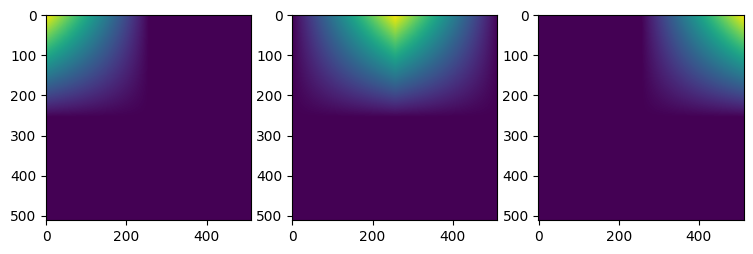

In [81]:
xr_w_phi = get_phi(xr_N)  # 一维插值尺度函数 phi

phi2d = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp, xr_w_phi.transpose(0, 1)])
print("phi2d shape: {}".format(phi2d.shape))
# 二维图像
figs, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    axs[i].imshow(phi2d[:,:,i].numpy(), cmap='viridis')

画个图解释：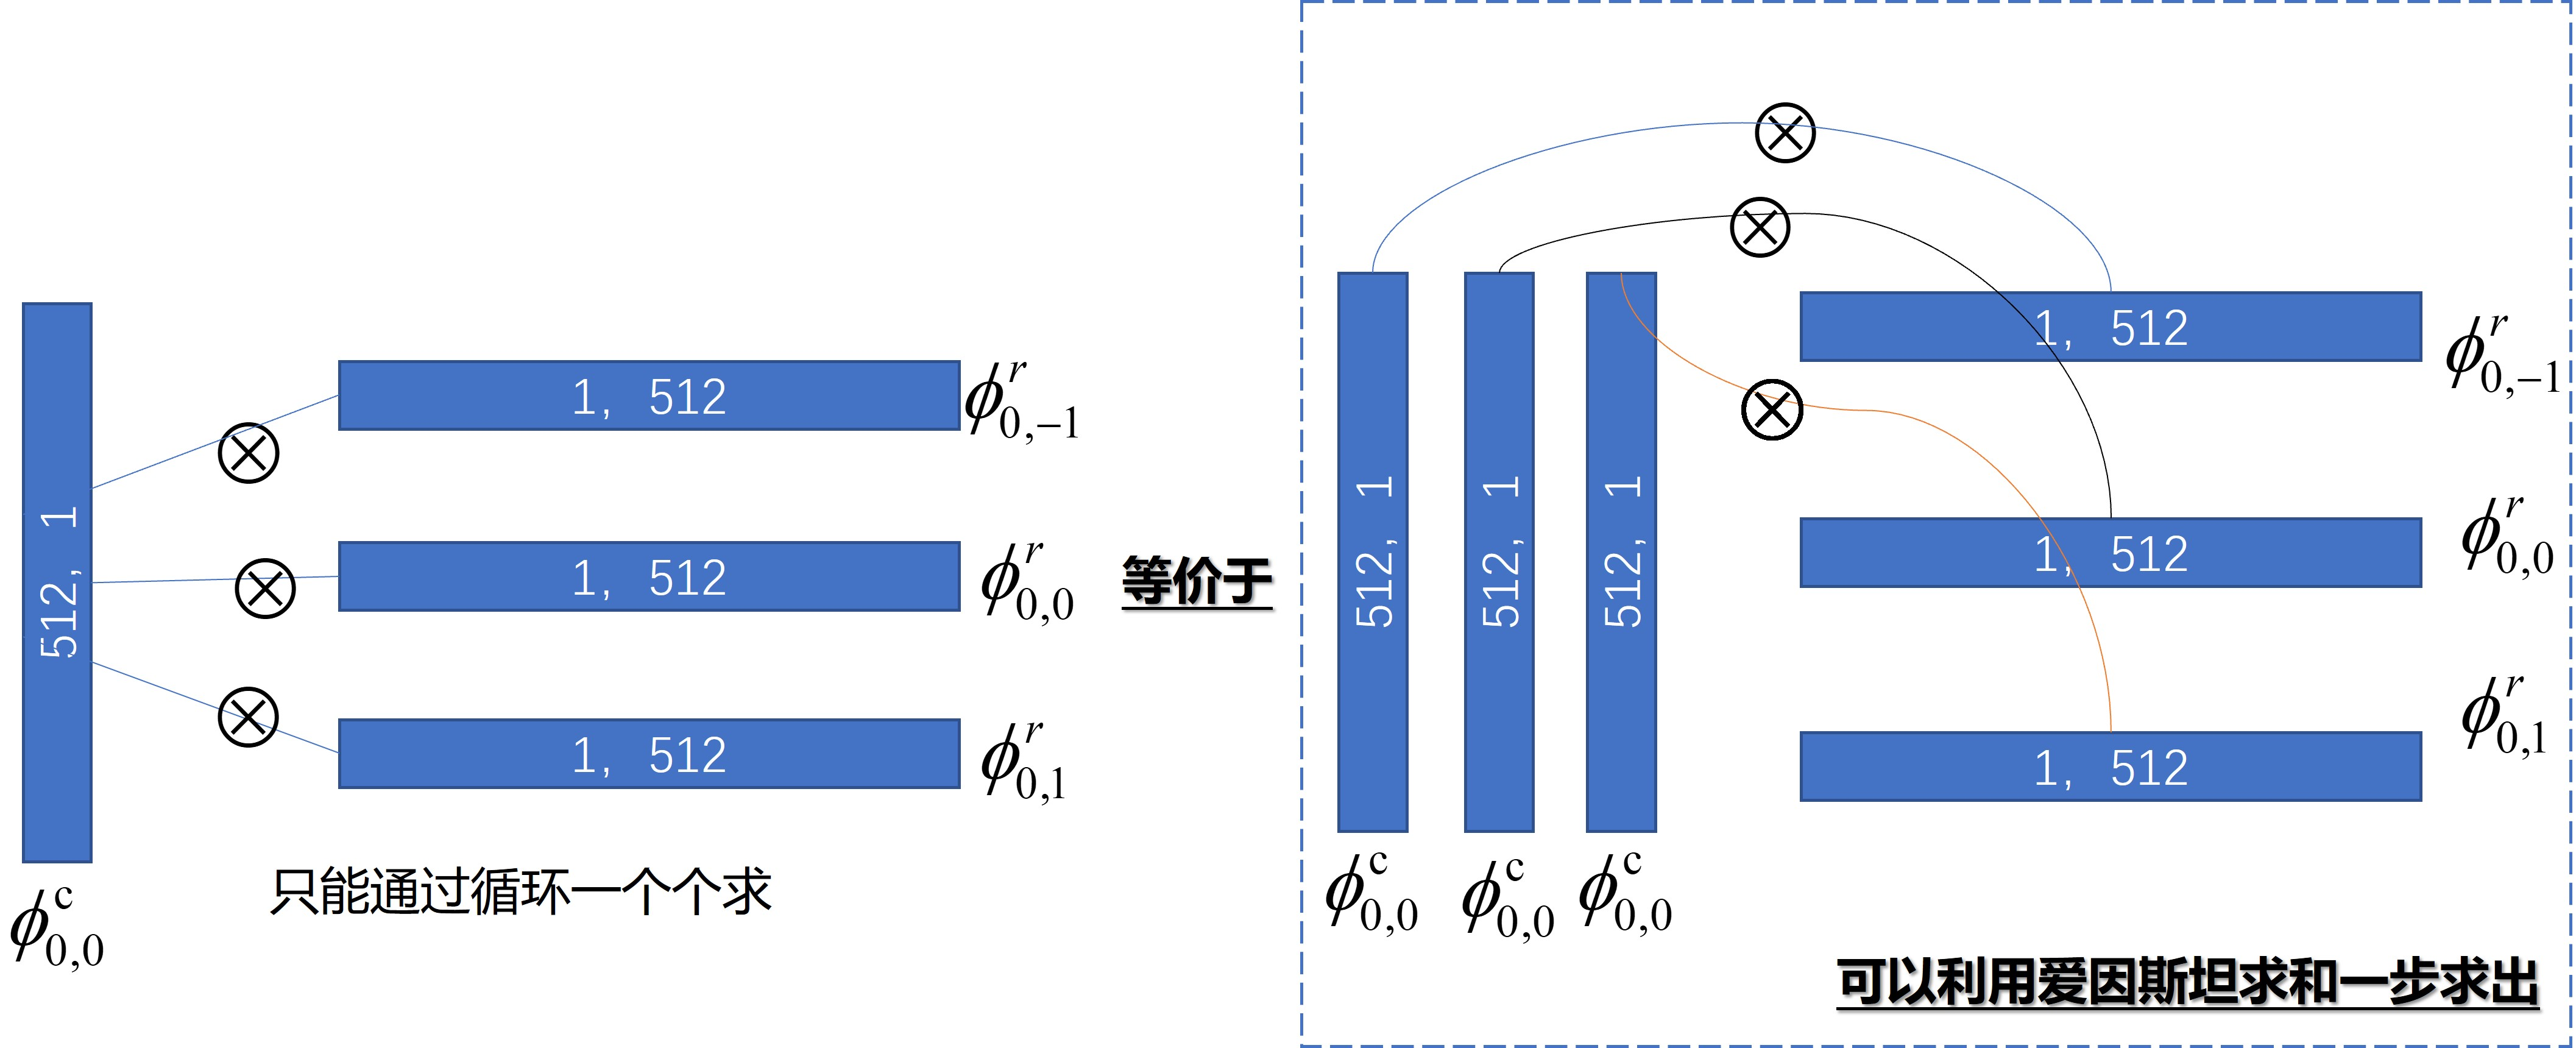

同样的，我们现在可以利用这个方法一次求出所有的插值尺度函数了。画个图解释就是这样：
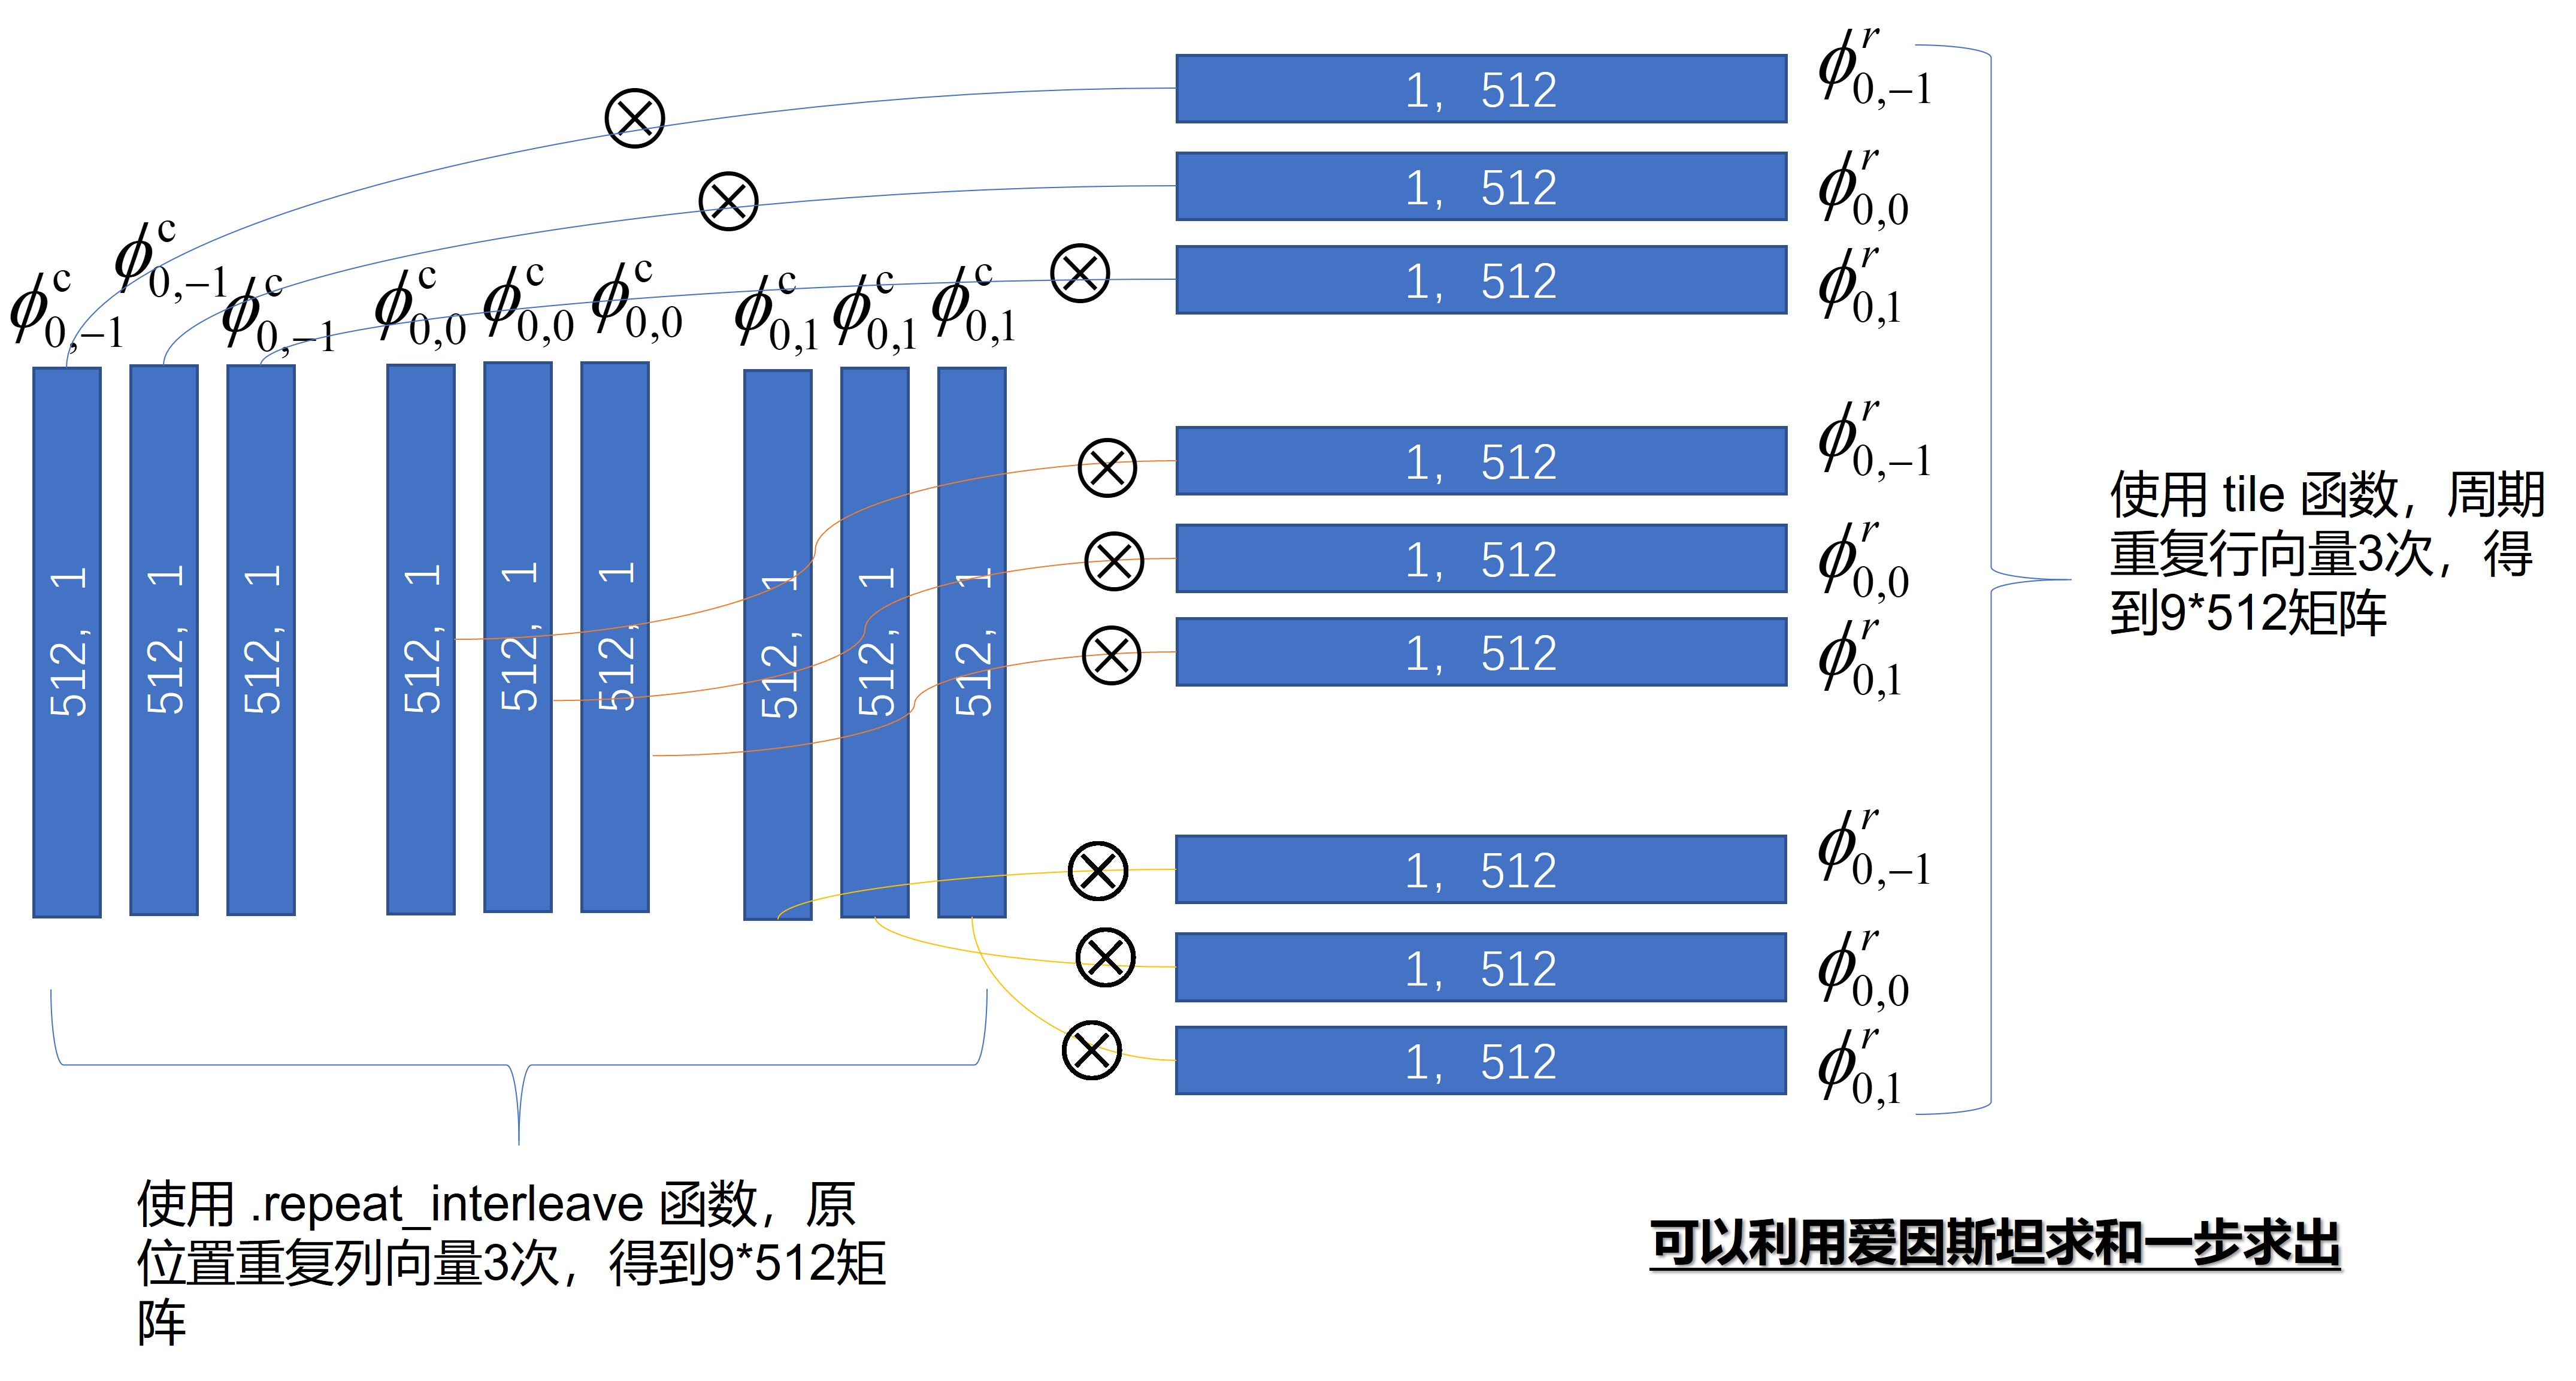

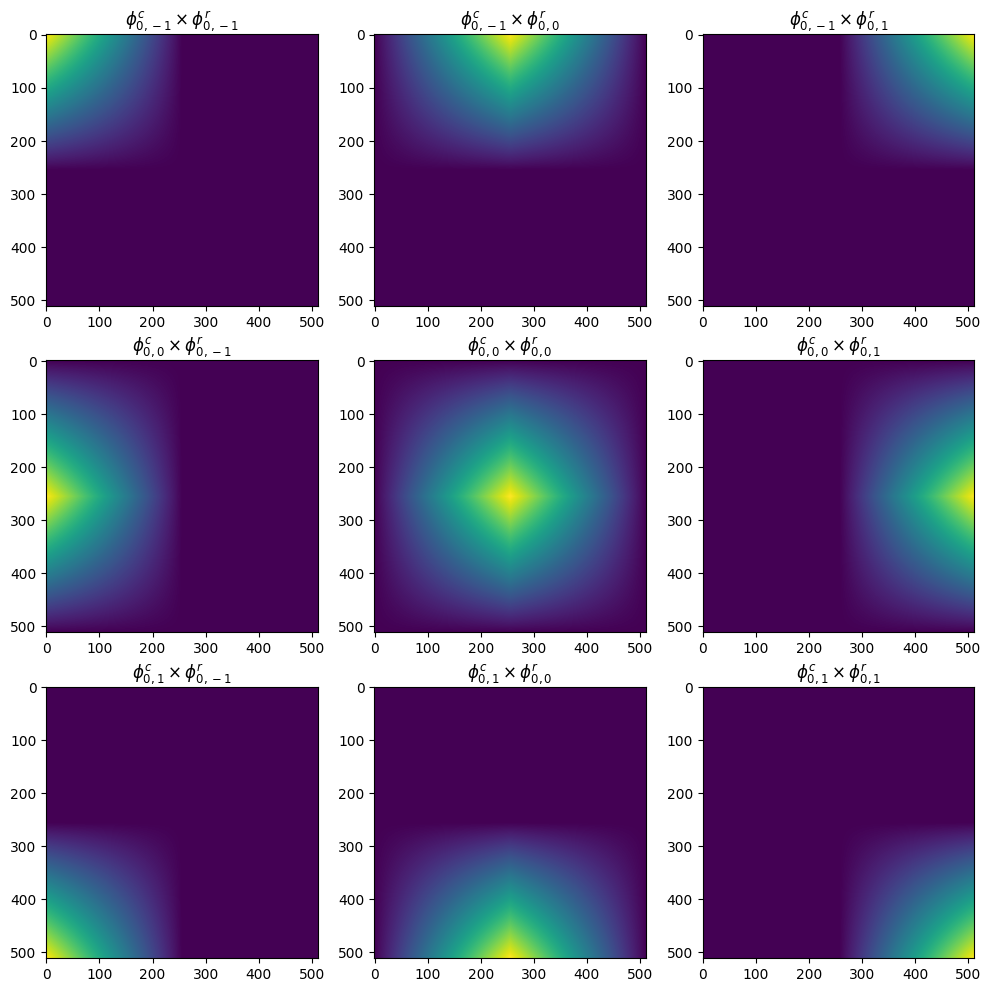

In [82]:
# 至此可以完全消除for循环了，代码修改为：
kc = torch.arange(-1, 2, 1)
kr = torch.arange(-1, 2, 1)

xc_N = (2**0)*xc - kc
xr_N = (2**0)*xr - kr

xc_w_phi = get_phi(xc_N)  # 一维插值尺度函数 phi
xr_w_phi = get_phi(xr_N)  # 一维插值尺度函数 phi

xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr_N.shape[1], 1)
xr_w_phi1_tmp = xr_w_phi.tile(1, xc_N.shape[1])

phi2d_all = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp, xr_w_phi1_tmp.transpose(0, 1)])

figs, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(phi2d_all[:,:,i*3+j].numpy(), cmap='viridis')
        axs[i, j].set_title("$\phi^c_{0, %d} \\times \phi^r_{0, %d}$" % (kc[i], kr[j]))

比较一下速度，以j=5为例，共求4225个插值尺度函数

In [83]:
import time

In [84]:
# 计时
start = time.time()
kc = torch.arange(-32, 33, 1)
kr = torch.arange(-32, 33, 1)
phi2d_all = torch.zeros((xc_N.shape[0], xr_N.shape[0], len(kc)*len(kr)))
for i in range(65):
    xc_N = (2**2)*xc - kc[i]
    for j in range(65):
        xr_N = (2**2)*xr - kr[j]   
        phi2d = torch.einsum('ij,jk->ik', [get_phi(xc_N), get_phi(xr_N).transpose(0, 1)])
        phi2d_all[:,:,i*65+j] = phi2d
print("Time: ", time.time()-start)

Time:  18.81386971473694


In [85]:
start = time.time()
kc = torch.arange(-32, 33, 1)
kr = torch.arange(-32, 33, 1)

xc_N = (2**5)*xc - kc
xr_N = (2**5)*xr - kr

xc_w_phi = get_phi(xc_N)  # 一维插值尺度函数 phi
xr_w_phi = get_phi(xr_N)  # 一维插值尺度函数 phi

xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr_N.shape[1], 1)
xr_w_phi1_tmp = xr_w_phi.tile(1, xc_N.shape[1])

phi2d_all = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp, xr_w_phi1_tmp.transpose(0, 1)])
print("Time: ", time.time()-start)

Time:  1.4765353202819824


速度提升了十倍有余。以上是算法提速的主要工作。但截至此句话, 上述过程并不是完美的，因为当j相对大的时候，向量化算法会构建一个极其庞大的矩阵，进而在爱因斯坦求和阶段会导致爆内存，拿空间换时间成本太高。

接下来实现二维插值小波变换，以及过程中对上述过程的改进，尽量不出现爆内存的可能。

In [86]:
def get_phi2d(xc, xr, block_size=10):  # 这个函数是上面最终代码的封装，可以直接调用。
    # block_size是分块大小，分块是为了节省内存，可以根据实际情况调整，这里的循环可以取得相对小，对时间影响不大。
    xc_w_phi = get_phi(xc)
    xr_w_phi = get_phi(xr)
    result_list = []
    xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr.shape[1], 1)
    xr_w_phi1_tmp = xr_w_phi.tile(1, xc.shape[1])
    for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
        xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
        xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
        result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
        result_list.append(result_block)
    return torch.cat(result_list, dim=2)

In [87]:
def get_psi2d(j, kc, kr, xc, xr, thidx, block_size=10):  # 这个函数本质上还是获取二维插值尺度函数，只是为了方便调用，所以命名为psi2d
    # 但在这里做了优化，直接获取了二维插值尺度函数的一部分，而不是全部，这样可以节省内存。这由thidx参数控制。在实际应用中，thidx是由其他函数返回的。
    # 这样处理解决了内存问题，但是牺牲了一些时间，因为这样处理会多次调用get_phi2d函数，而get_phi2d函数中有循环，循环次数是thidx.shape[0]。
    # 不过这个时间损耗相比原来的循环，是可以接受的。
    xc_w_psi = get_phi((2 ** (j+1)) * xc - (2*kc+1))
    xr_w_psi = get_phi((2 ** (j+1)) * xr - (2*kr+1))
    result_list = []
    used_c = thidx // xc_w_psi.shape[1]  # thidx是一个一维张量，这里是列索引
    used_r = thidx % xc_w_psi.shape[1]  # thidx是一个一维张量，这里是行索引
    xc_w_phi1_tmp = xc_w_psi[:, used_c]  # 使用的一维插值尺度函数 psi
    xr_w_phi1_tmp = xr_w_psi[:, used_r]  # 使用的一维插值尺度函数 psi
    # 上述这样处理在j比较大的时候，可以节省计算, 节省大量内存。
    for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
        xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
        xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
        result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
        result_list.append(result_block)
    return torch.cat(result_list, dim=2)

In [88]:
def get_idx2d(xc, xr, x_transc, x_transr):  # 获取二维函数的列坐标和行坐标的索引（比如，x=-1的索引是0，x=1的索引是511）
    # xc, xr: 二维函数的列坐标和行坐标
    # x_transc, x_transr: 二维函数的列坐标和行坐标的变换后的值
    diffc = torch.abs(xc - x_transc)  # 计算差值
    diffr = torch.abs(xr - x_transr)  # 计算差值
    _, idxc = torch.min(diffc, dim=0)  # 获取索引
    _, idxr = torch.min(diffr, dim=0)  # 获取索引
    idxc_mesh, idxr_mesh = torch.meshgrid(idxc, idxr, indexing='ij')  # 生成索引网格
    idxs = torch.vstack((idxc_mesh.flatten(), idxr_mesh.flatten())).t()  # 将索引网格展平
    return idxs

In [89]:
def get_Iwt_l2d(imgl, xc, xr, j):  # 二维插值小波变换，j0级别下的逼近结果
    kc = torch.arange(-2 ** j, 2 ** j + 1, 1)  # j0级别下的列配点索引
    kr = torch.arange(-2 ** j, 2 ** j + 1, 1)  # j0级别下的行配点索引
    phi2dj0 = get_phi2d((2 ** j) * xc - kc, (2 ** j) * xr - kr)  # j0级别下，各配点的二维插值尺度函数的集合
    x_jkc, x_jkr = kc * (2 ** (-j)), kr * (2 ** (-j))  # j0级别下的配点坐标
    idxs = get_idx2d(xc, xr, x_jkc, x_jkr)  # j0级别下的配点索引
    f_xjk = imgl[idxs[:, 0], idxs[:, 1]]  # j0级别下的配点函数值
    Ijfs = torch.tensordot(phi2dj0, f_xjk, dims=([2], [0]))  # j0级别下的逼近结果
    return Ijfs, [idxs.tolist()]  # 返回逼近结果和配点索引

然后是求取后续级别尺度下的“小波系数”——也就是$\alpha$

In [90]:
def get_alpha_jk2d(img, xc, xr, j, kc, kr, u, th):
    x_jkc, x_jkr = (2*kc+1) * (2 ** (-j-1)), (2*kr+1) * (2 ** (-j-1))  # j级别下的所有未经过阈值筛选的配点坐标
    idxs = get_idx2d(xc, xr, x_jkc, x_jkr)  # j级别下的所有未经过阈值筛选的配点索引
    f_yjk = img[idxs[:, 0], idxs[:, 1]]  # j级别下的所有未经过阈值筛选的配点位置的真实函数值
    diff = f_yjk - u[idxs[:, 0], idxs[:, 1]]  # j级别下的所有未经过阈值筛选的配点位置的真实函数值与逼近函数值的差（插值小波系数）
    thidx = torch.where(torch.abs(diff) > th)[0]  # j级别下的所有未经过阈值筛选的配点位置的真实函数值与逼近函数值的差的绝对值大于阈值的索引
    if thidx.shape[0] > 0:  # 如果存在差的绝对值大于阈值的索引
        return diff[thidx], idxs[thidx], thidx  # 返回插值小波系数、配点索引和插值小波系数的索引
    else:
        return torch.tensor([0]), torch.tensor([[0, 0]]), thidx  # 否则返回0

In [91]:
def get_Iwt2d(self, img, xc, xr, j0, J, e):
    approx, indicies = self.get_Iwt_l2d(img, xc, xr, j0)  # j0级别下的逼近结果
    if J <= j0:
        return approx, indicies  # 如果J小于等于j0，直接返回逼近结果
    for j in range(j0, J):  # 从j0级别到J级别
        idxs = []  # 用于存储配点索引
        details = torch.zeros_like(approx)  # 用于存储细节
        kc = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)  # j级别下的列配点索引
        kr = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)  # j级别下的行配点索引
        alpha_jk, idx, thidx = self.get_alpha_jk2d(img, xc, xr, j, kc, kr, approx, th=e)  # j级别下的插值小波系数、配点索引和插值小波系数的索引
        if thidx.shape[0] > 0:  # 如果存在差的绝对值大于阈值的索引
            idxs.append(idx.tolist())  # 将配点索引添加到idxs中
            psi_jk = self.get_psi2d(j, kc, kr, xc, xr, thidx)  # j级别下的插值尺度函数
            details = torch.tensordot(psi_jk, alpha_jk, dims=([2], [0]))  # j级别下的细节
        else:
            break
        approx = approx + details  # 更新逼近结果
        indicies.append(idxs[0])  # 将配点索引添加到indicies中
    return approx, indicies  # 返回逼近结果和配点索引

以上是二维插值小波变换的代码，可以直接调用get_Iwt2d函数进行变换。
这只是为了寻找配点，而后续的涉及偏微分方程的求解，交给了PINN，因此在这里没有实现配点位置的导数计算。

下面将其封装为类，通过pytorch放入GPU中进行计算，方便与PINN结合在一起。

In [92]:
class torchIWT(torch.nn.Module):

    def __init__(self):
        super(torchIWT, self).__init__()

    def get_phi(self, x):

        out = torch.zeros_like(x)
        out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
        out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
        return out

        # mm = (3.2**2) * (1**2)
        # t = torch.pi * x / 1
        # ss = torch.sin(t)
        # ee = torch.exp(-torch.square(x) / (2 * mm))
        # out = torch.divide((ss * ee), t)
        # out[torch.where(t==0.)] = 1.
        # return out


    def get_phi2d(self, xc, xr, block_size=10):
        xc_w_phi = self.get_phi(xc)
        xr_w_phi = self.get_phi(xr)
        result_list = []
        xc_w_phi1_tmp = xc_w_phi.repeat_interleave(xr.shape[1], 1)
        xr_w_phi1_tmp = xr_w_phi.tile(1, xc.shape[1])
        for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
            xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
            xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
            result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
            result_list.append(result_block)
        return torch.cat(result_list, dim=2)

    def get_psi2d(self, j, kc, kr, xc, xr, thidx, block_size=10):
        xc_w_psi = self.get_phi((2 ** (j+1)) * xc - (2*kc+1))
        xr_w_psi = self.get_phi((2 ** (j+1)) * xr - (2*kr+1))
        result_list = []
        used_c = thidx // xc_w_psi.shape[1]
        used_r = thidx % xc_w_psi.shape[1]
        xc_w_phi1_tmp = xc_w_psi[:, used_c]
        xr_w_phi1_tmp = xr_w_psi[:, used_r]
        for i in range(0, xc_w_phi1_tmp.shape[1], block_size):
            xc_w_phi1_tmp_block = xc_w_phi1_tmp[:, i:i+block_size]
            xr_w_phi1_tmp_block = xr_w_phi1_tmp[:, i:i+block_size]
            result_block = torch.einsum('ij,jk->ikj', [xc_w_phi1_tmp_block, xr_w_phi1_tmp_block.transpose(0, 1)])
            result_list.append(result_block)
        return torch.cat(result_list, dim=2)


    def get_idx2d(self, xc, xr, x_transc, x_transr):
        diffc = torch.abs(xc - x_transc)
        diffr = torch.abs(xr - x_transr)
        _, idxc = torch.min(diffc, dim=0)
        _, idxr = torch.min(diffr, dim=0)
        idxc_mesh, idxr_mesh = torch.meshgrid(idxc, idxr, indexing='ij')
        idxs = torch.vstack((idxc_mesh.flatten(), idxr_mesh.flatten())).t()
        return idxs



    def get_Iwt_l2d(self, imgl, xc, xr, j):
        kc = torch.arange(-2 ** j, 2 ** j + 1, 1)
        kr = torch.arange(-2 ** j, 2 ** j + 1, 1)
        phi2dj0 = self.get_phi2d((2 ** j) * xc - kc, (2 ** j) * xr - kr)
        x_jkc, x_jkr = kc * (2 ** (-j)), kr * (2 ** (-j))
        idxs = self.get_idx2d(xc, xr, x_jkc, x_jkr)
        f_xjk = imgl[idxs[:, 0], idxs[:, 1]]
        Ijfs = torch.tensordot(phi2dj0, f_xjk, dims=([2], [0]))
        return Ijfs, [idxs.tolist()]


    def get_alpha_jk2d(self, img, xc, xr, j, kc, kr, u, th):
        x_jkc, x_jkr = (2*kc+1) * (2 ** (-j-1)), (2*kr+1) * (2 ** (-j-1))
        idxs = self.get_idx2d(xc, xr, x_jkc, x_jkr)
        f_yjk = img[idxs[:, 0], idxs[:, 1]]
        diff = f_yjk - u[idxs[:, 0], idxs[:, 1]]
        thidx = torch.where(torch.abs(diff) > th)[0]
        if thidx.shape[0] > 0:
            return diff[thidx], idxs[thidx], thidx
        else:
            return torch.tensor([0]), torch.tensor([[0, 0]]), thidx


    def get_Iwt2d(self, img, xc, xr, j0, J, e):
        approx, indicies = self.get_Iwt_l2d(img, xc, xr, j0)  # 逼近结果
        if J <= j0:
            return approx, indicies
        for j in range(j0, J):
            idxs = []
            details = torch.zeros_like(approx)
            kc = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)
            kr = torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5)
            # th = e * (2 ** j)
            alpha_jk, idx, thidx = self.get_alpha_jk2d(img, xc, xr, j, kc, kr, approx, th=e)
            if thidx.shape[0] > 0:
                idxs.append(idx.tolist())
                psi_jk = self.get_psi2d(j, kc, kr, xc, xr, thidx)
                details = torch.tensordot(psi_jk, alpha_jk, dims=([2], [0]))
            else:
                break
            approx = approx + details
            indicies.append(idxs[0])
        return approx, indicies

In [93]:
def show_approx(imgl, approx, indicies, level_points, s=5, cmap='jet', show_2d_points=True, al=0.5):
    xa = np.arange(approx.shape[0])
    ya = np.arange(approx.shape[1])
    xaa, yaa = np.meshgrid(xa, ya)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xaa, yaa, approx.T, cmap='jet', alpha=al)

    idxnp = []
    if level_points == -1 or level_points >= len(indicies):
        for i in indicies:
            idxnp = idxnp + i
    else:
        idxnp = indicies[level_points]
    idxs = np.array(idxnp)
    idxsu = np.unique(idxs, axis=0).T
    idxsut = (idxsu[1,:], idxsu[0,:])
    ax.scatter(xaa[idxsut], yaa[idxsut], approx.T[idxsut], color='black', marker='o', s=2*s)

    ax.set_title('points_num: {}'.format(len(idxnp)))

    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(approx, cmap=cmap)
    axs[0].set_title('approx_img')
    axs[1].imshow(imgl, cmap=cmap)
    axs[1].set_title('raw_img')
    if show_2d_points:
        if cmap == 'gray':
            color = 'red'
        else:
            color = 'black'
        points = list(zip(idxsut[0], idxsut[1]))
        x1, y1 = zip(*points)
        axs[1].scatter(x1, y1, color=color, s=s)

    plt.show()


def show_3d_points(approx, indicies, level_points=2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    indicieslevel = len(indicies)
    if level_points == -1 or level_points >= len(indicies):
        pass
    else:
        indicies = [indicies[level_points]]
    for idx, i in enumerate(indicies):
        i = np.array(i)
        idxsu = np.unique(i, axis=0).T
        if len(idxsu) == 0:
            continue
        idxsut = (idxsu[1,:], idxsu[0,:])
        xa = np.arange(approx.shape[0])
        ya = np.arange(approx.shape[1])
        xaa, yaa = np.meshgrid(xa, ya)
        amm = np.zeros_like(approx)
        if level_points == -1 or level_points >= indicieslevel:
            d = idx
        else:
            d = level_points
        amm[i[:,0], i[:,1]] = d
        ax.set_xlim([0, approx.shape[0]])
        ax.set_ylim([0, approx.shape[1]])
        ax.set_zlim([0, indicieslevel])
        ax.scatter(xaa[idxsut], yaa[idxsut], amm.T[idxsut], marker='o', s=(indicieslevel-idx+1)*5)
    plt.show()

In [94]:
iwtmodel = torchIWT()
iwtmodel.cuda()
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc, xr, j0, J, e)

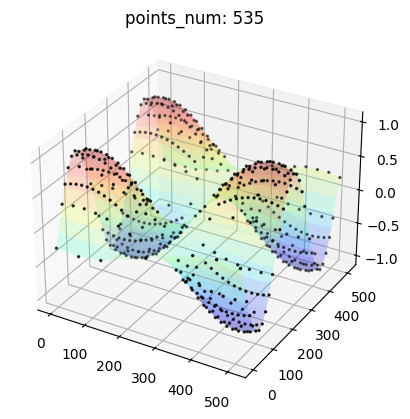

<Figure size 640x480 with 0 Axes>

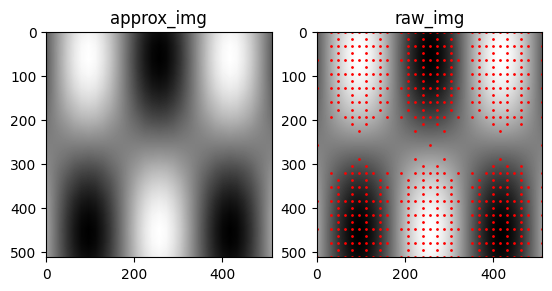

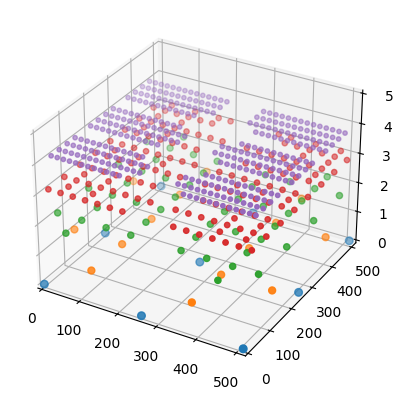

In [95]:
l=-1
show_approx(imgl, approx, indicies, level_points=-1, s=1, cmap='gray', show_2d_points=True, al=0.2)
show_3d_points(approx, indicies, level_points=l)

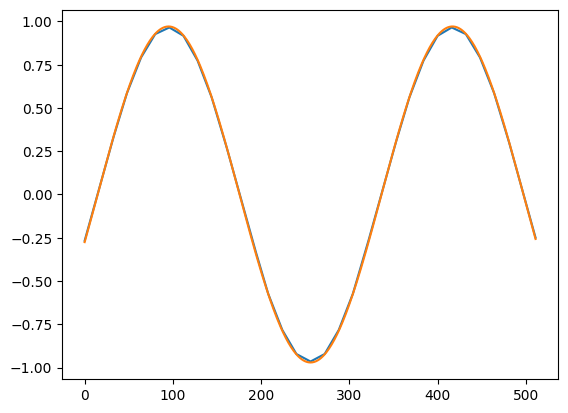

In [96]:
plt.plot(approx[24,:])
plt.plot(imgl[24,:])